In [10]:
import pandas as pd

# Load the CSV file
file_path = "csvs/ensemble_results_only_custom_weights.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.head()

,Name,random_seed,ensemble_variant,learning_rate,model_name,val_loss,test_f1_weighted,classification_report.macro avg.f1-score
0,still-sweep-180,9,advanced,0.00005,efficientnet-b2,0.922725,0.768186,0.342051
1,magic-sweep-179,8,advanced,0.00005,efficientnet-b2,0.964094,0.803047,0.608408
2,peach-sweep-178,7,advanced,0.00005,efficientnet-b2,0.857078,0.775210,0.481205
3,skilled-sweep-177,6,advanced,0.00005,efficientnet-b2,0.882469,0.802970,0.598889
4,peachy-sweep-176,5,advanced,0.00005,efficientnet-b2,0.808403,0.798198,0.519520


In [7]:
# Group by ensemble_variant and model_name, then find the learning_rate with the best average test_f1_weighted
best_learning_rates = (
    df.groupby(["ensemble_variant", "model_name", "learning_rate"])[
        "test_f1_individual"
    ]
    .mean()
    .reset_index()
)

# For each ensemble_variant and model_name, find the learning_rate with the highest average test_f1_weighted
best_learning_rates = best_learning_rates.loc[
    best_learning_rates.groupby(["ensemble_variant", "model_name"])[
        "test_f1_individual"
    ].idxmax()
]

# Display the results
print(best_learning_rates)

   ensemble_variant       model_name  learning_rate  test_f1_individual
1          advanced      MobileVit-s         0.0005            0.576184
4          advanced  efficientnet-b2         0.0005            0.546033
8            medium      MobileVit-s         0.0050            0.658126
11           medium  efficientnet-b2         0.0050            0.523167
14           simple      MobileVit-s         0.0050            0.563507
17           simple  efficientnet-b2         0.0050            0.491139


In [11]:
# Group by ensemble_variant and model_name, then find the learning_rate with the best average test_f1_weighted
best_learning_rates = (
    df.groupby(["ensemble_variant", "model_name", "learning_rate"])["test_f1_weighted"]
    .mean()
    .reset_index()
)

# For each ensemble_variant and model_name, find the learning_rate with the highest average test_f1_weighted
best_learning_rates = best_learning_rates.loc[
    best_learning_rates.groupby(["ensemble_variant", "model_name"])[
        "test_f1_weighted"
    ].idxmax()
]

# Display the results
print(best_learning_rates)

   ensemble_variant       model_name  learning_rate  test_f1_weighted
1          advanced      MobileVit-s        0.00050          0.828961
3          advanced  efficientnet-b2        0.00005          0.783264
6            medium      MobileVit-s        0.00005          0.813178
11           medium  efficientnet-b2        0.00500          0.817720
14           simple      MobileVit-s        0.00500          0.806763
17           simple  efficientnet-b2        0.00500          0.793870


In [12]:
# Merge the original dataframe with the best learning rates dataframe on ensemble_variant, model_name, and learning_rate
merged_df = pd.merge(
    df,
    best_learning_rates[["ensemble_variant", "model_name", "learning_rate"]],
    on=["ensemble_variant", "model_name", "learning_rate"],
    how="inner",
)

# Save the merged dataframe to a new CSV file
filtered_file_path = "csvs/filtered_ensemble_results_only_custom_weights.csv"
merged_df.to_csv(filtered_file_path, index=False)

print(f"Filtered results saved to {filtered_file_path}")

Filtered results saved to filtered_ensemble_results_only_custom_weights.csv


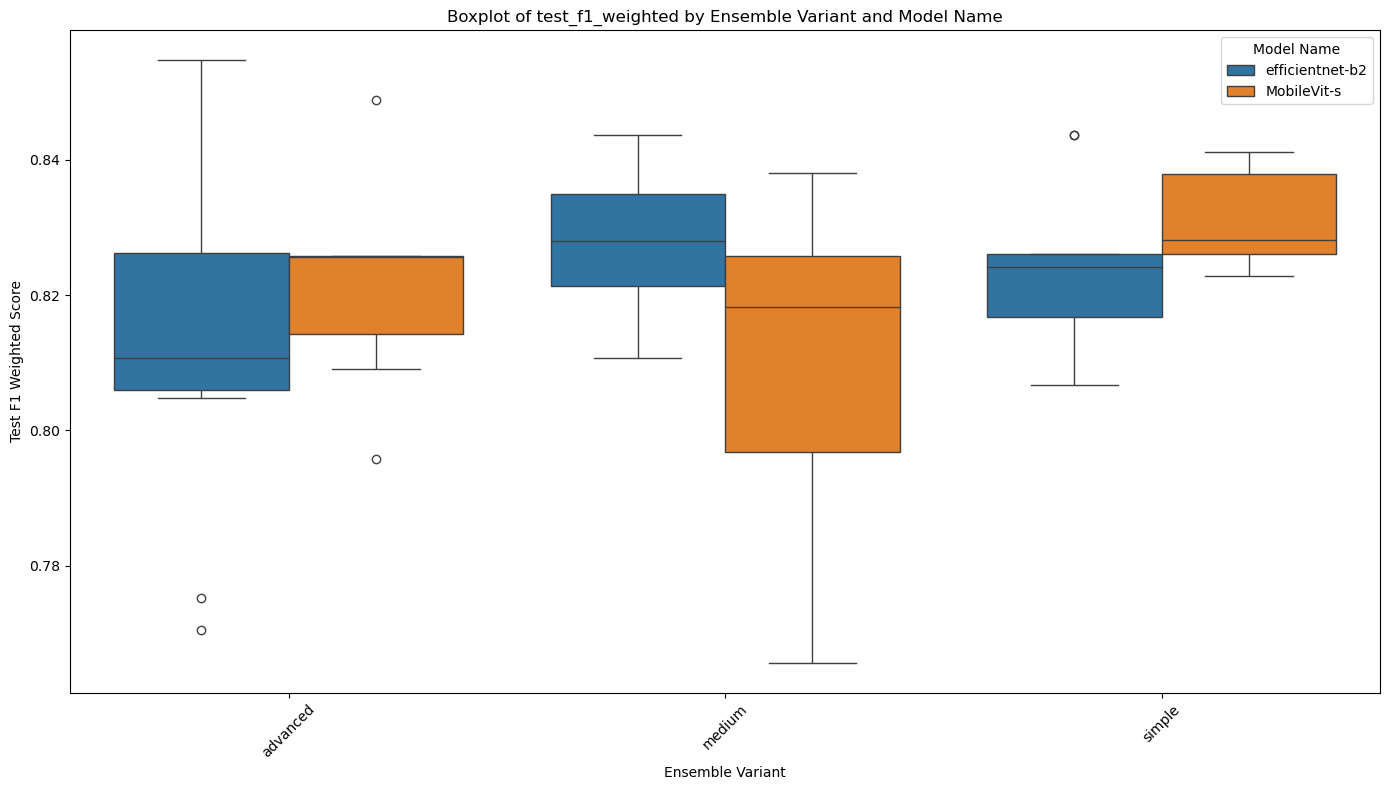

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the filtered dataframe
filtered_file_path = "filtered_ensemble_results.csv"
filtered_df = pd.read_csv(filtered_file_path)

# Create a boxplot for the different model_name, ensemble_variant combinations
plt.figure(figsize=(14, 8))
sns.boxplot(
    x="ensemble_variant", y="test_f1_weighted", hue="model_name", data=filtered_df
)
plt.title("Boxplot of test_f1_weighted by Ensemble Variant and Model Name")
plt.xlabel("Ensemble Variant")
plt.ylabel("Test F1 Weighted Score")
plt.legend(title="Model Name")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

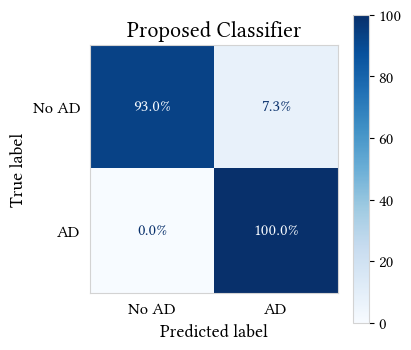

0.9326255614536546


In [1]:
import torch
from torchvision import transforms
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
from transformers import MobileViTImageProcessor
import wandb

from dataset import MRIFeatureDataModule, MRIFeatureDataset
from models import SimpleEnsembleModel, AdvancedEnsembleModel, MediumEnsembleModel
from utils import get_best_device, LoginCredentials

from datetime import datetime
import lightning.pytorch as pl
import torch
import numpy as np
import random
from sklearn.metrics import f1_score
from sklearn.metrics import (
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)


model_name = "efficientnet-b2"
ensemble_variant = "advanced"
learning_rate = 0.005
batch_size = 160
random_seed = 0


device = get_best_device()
feature_folder = "extracted_features/student/"
train_pkl = f"{feature_folder}{model_name}_train_features_pooled.pkl"
val_pkl = f"{feature_folder}{model_name}_val_features_pooled.pkl"
test_pkl = f"{feature_folder}{model_name}_test_features_pooled.pkl"
num_classes = 4
as_sequence = ensemble_variant == "advanced"

data_module = MRIFeatureDataModule(
    train_pkl=train_pkl,
    val_pkl=val_pkl,
    test_pkl=test_pkl,
    as_sequence=as_sequence,
    batch_size=batch_size,
)
data_module.setup()
test_loader = data_module.test_dataloader()
featuremap_length = data_module.featuremap_length
sequence_length = data_module.sequence_length

if ensemble_variant == "simple":
    feature_size = featuremap_length * sequence_length
    model = SimpleEnsembleModel(
        feature_size=feature_size, num_classes=num_classes, lr=learning_rate
    )
elif ensemble_variant == "medium":
    feature_size = featuremap_length * sequence_length
    model = MediumEnsembleModel(
        feature_size=feature_size, num_classes=num_classes, lr=learning_rate
    )
elif ensemble_variant == "advanced":
    feature_size = featuremap_length
    model = AdvancedEnsembleModel(
        feature_size=feature_size,
        num_classes=num_classes,
        lr=learning_rate,
        max_seq_length=sequence_length,
    )


# Load best model for testing
# best_model_path = f"model_checkpoints/ensemble_{ensemble_variant}_{model_name}/lr_{learning_rate}-v{random_seed}.ckpt"
best_model_path = f"model_checkpoints/ensemble_{ensemble_variant}_{model_name}/lr_{learning_rate}.ckpt"
if ensemble_variant == "simple":
    best_model_class = SimpleEnsembleModel
    feature_size = featuremap_length * sequence_length
elif ensemble_variant == "medium":
    best_model_class = MediumEnsembleModel
    feature_size = featuremap_length * sequence_length
elif ensemble_variant == "advanced":
    best_model_class = AdvancedEnsembleModel
    feature_size = featuremap_length

best_model = best_model_class.load_from_checkpoint(
    best_model_path,
    feature_size=feature_size,
    num_classes=num_classes,
    lr=learning_rate,
    max_seq_length=sequence_length,
)
best_model = best_model.to(device)
best_model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device).float()
        outputs = best_model(inputs)
        preds = torch.argmax(outputs, dim=1)

        # Convert predictions and labels to binary values
        binary_preds = (preds > 0).int()
        binary_labels = (labels > 0).int()

        # Extend the lists with the binary values
        all_preds.extend(binary_preds.cpu().numpy())
        all_labels.extend(binary_labels.cpu().numpy())

    # Calculate metrics
    f1_weighted = f1_score(all_labels, all_preds, average="weighted")
    f1_individual = f1_score(all_labels, all_preds, average="macro")
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    conf_matrix = confusion_matrix(all_labels, all_preds)
    classification_rep = classification_report(all_labels, all_preds, output_dict=True)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from utils import set_plot_style

colors = set_plot_style()

# Assuming all_preds and all_labels are defined as lists
# If not, you need to convert them into lists
# all_preds = list(all_preds)
# all_labels = list(all_labels)

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Convert the confusion matrix to percentages
cm_percentage = cm / cm.sum(axis=1)[:, np.newaxis] * 100

# Display the confusion matrix with custom labels and percentage values
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_percentage, display_labels=["No AD", "AD"]
)

# Plot the confusion matrix with a smaller figure size
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Update the text in the confusion matrix plot
for text in ax.texts:
    text.set_text(f"{float(text.get_text()):.1f}%")
    text.set_fontsize(12)  # Adjust the font size as needed

plt.title("Proposed Classifier")
plt.savefig("plots/confusion_matrix_proposed.pdf", bbox_inches="tight", format="pdf")
plt.show()
print(f1_score(all_labels, all_preds, average="macro"))

The age threshold to detect all patients with AD is: 62


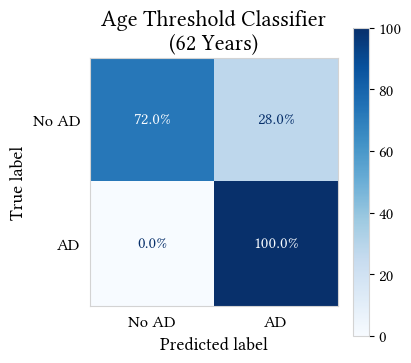

The age threshold to detect all patients with AD is: 62


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the CSV file
file_path = "Data/metadata_for_preprocessed_files.csv"
data = pd.read_csv(file_path)

# Extract relevant columns and drop rows with missing values
cdr_age_data = data[["CDR", "Age"]].dropna()

# Convert CDR to a categorical type
cdr_age_data["CDR"] = cdr_age_data["CDR"].astype(float)

# Convert CDR labels to 0 (No AD) and 1 (AD)
cdr_age_data["CDR"] = cdr_age_data["CDR"].apply(lambda x: 0 if x == 0 else 1)

# Determine the age threshold to detect all patients with AD
age_threshold = cdr_age_data[cdr_age_data["CDR"] == 1]["Age"].min()
print(f"The age threshold to detect all patients with AD is: {age_threshold}")

# Create predictions based on the age threshold
cdr_age_data["Pred"] = cdr_age_data["Age"].apply(
    lambda x: 1 if x >= age_threshold else 0
)

# Compute the confusion matrix
cm = confusion_matrix(cdr_age_data["CDR"], cdr_age_data["Pred"])

# Convert the confusion matrix to percentages
cm_percentage = cm / cm.sum(axis=1)[:, np.newaxis] * 100

# Display the confusion matrix with custom labels and percentage values
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_percentage, display_labels=["No AD", "AD"]
)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Update the text in the confusion matrix plot
for text in ax.texts:
    text.set_text(f"{float(text.get_text()):.1f}%")
    text.set_fontsize(12)  # Adjust the font size as needed

plt.title("Age Threshold Classifier\n(62 Years)")
plt.savefig(
    "plots/confusion_matrix_age_threshold.pdf", bbox_inches="tight", format="pdf"
)
plt.show()

# Output the age threshold
print(f"The age threshold to detect all patients with AD is: {age_threshold}")

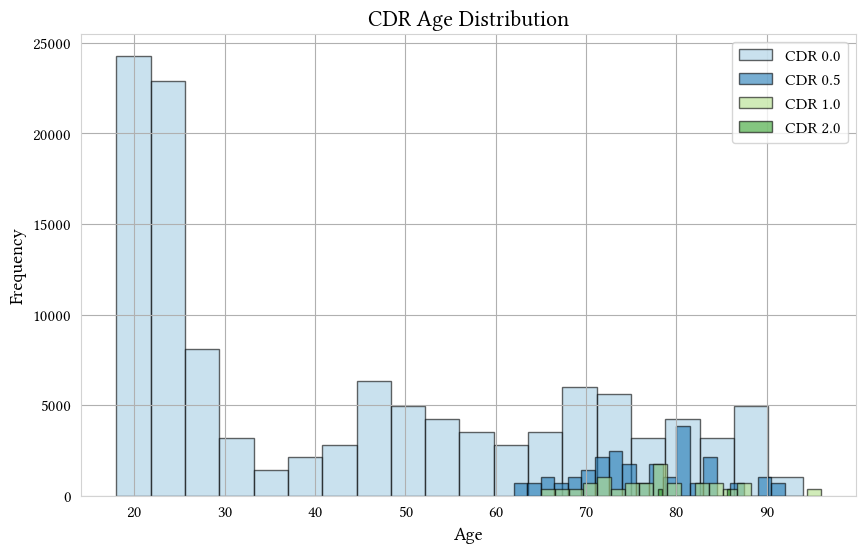

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "Data/metadata_for_preprocessed_files.csv"
data = pd.read_csv(file_path)

# Extract relevant columns and drop rows with missing values
cdr_age_data = data[["CDR", "Age"]].dropna()

# Convert CDR to a categorical type
cdr_age_data["CDR"] = cdr_age_data["CDR"].astype(float)

# Plot the CDR age distribution
plt.figure(figsize=(10, 6))

# Plot histogram for each CDR category
for cdr_value in cdr_age_data["CDR"].unique():
    subset = cdr_age_data[cdr_age_data["CDR"] == cdr_value]
    plt.hist(
        subset["Age"], bins=20, alpha=0.6, label=f"CDR {cdr_value}", edgecolor="black"
    )

plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("CDR Age Distribution")
plt.legend()
plt.grid(True)
plt.show()